## Quora Insincere Question Classification

### Abstract 

The objective is to predict whether a question asked on Quora is sincere or not.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people

### Part A - Deep Learning model

I will try various Deep Learning Algorithms to see which works best of this dataset like LSTM, SimpleRNN, Conv1D, GRU etc. I will also use pre-trained word embeddings in few algorithms. As a baseline, I will use Naive Bayes and Logistic regression for this. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time, gc, warnings

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS

np.random.seed(42)
color = sns.color_palette("Set2")
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
os.chdir(r'N:\ADVANCE DATA SCIENCE\ASSIGNMENTS\Assignment 3')

In [3]:
df_Quora = pd.read_csv('quora_questions_.csv')

In [4]:
df_Quora[df_Quora.target == 0].head(5)

qid                                      question_text  \
0  69d762db89f677e2b38d                 How can I live fully happier life?   
1  de052885a7cb6483c482  What is the difference between IT and computer...   
2  5cf30b565aa71a3ce65c   Why a suit is the dress code of business people?   
3  a2483d6b6debff584f87  How can you get the earnest money loan for a b...   
4  c93fef8401e553bbee16  Why would an atheist care if others celebrate ...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [5]:
df_Quora[df_Quora.target == 1].head(5)

qid  \
61266  9d91dabfc5358b6e9b4a   
61267  cafdbedf2152a331cf88   
61268  877e654f6097f6dde056   
61269  341b769d29966cae4b16   
61270  136b7b3b0dc24a6256c0   

                                           question_text  target  
61266  Has Trump (since becoming president), ever com...       1  
61267  Why Turkish people and Iranians look white des...       1  
61268  Do Hungarians envy Romania, because they are b...       1  
61269  I just got a message that my answer had been "...       1  
61270                What does black man cum taste like?       1

In [6]:
df_Quora.shape

(93590, 3)

In [7]:
df_Quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93590 entries, 0 to 93589
Data columns (total 3 columns):
qid              93590 non-null object
question_text    93590 non-null object
target           93590 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.1+ MB


#### Target Column Distribution

In [8]:
df_Quora.target.value_counts()

0    61266
1    32324
Name: target, dtype: int64

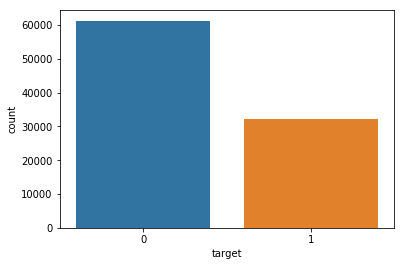

In [9]:
sns.countplot(df_Quora.target, label='Count')

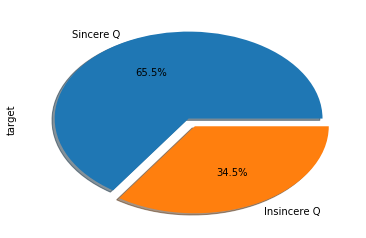

In [10]:
df_Quora.target.value_counts().plot.pie(autopct='%1.1f%%', labels=['Sincere Q', 'Insincere Q'], explode=[0, 0.1], shadow=True) 
#(kind='pie', autopct='%1.1f%%')

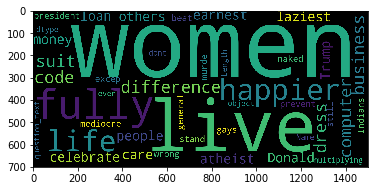

In [11]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 101, 
                    width=1500, 
                    height=700)
wordcloud.generate(str(df_Quora['question_text']))
plt.imshow(wordcloud)

#### Question Length Distribution

In [12]:
df_Quora['ques_len'] = df_Quora.question_text.apply(lambda x: len(x.split()))

sincere = df_Quora[df_Quora.target == 0]
insincere = df_Quora[df_Quora.target == 1]

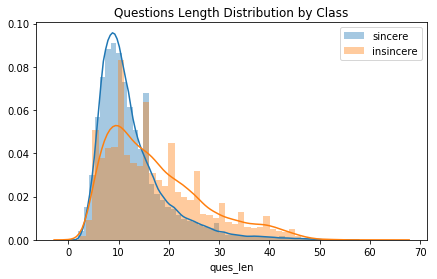

In [13]:
plt.figure(figsize = (7, 4))
sns.distplot(sincere['ques_len'], hist = True, label = 'sincere')
sns.distplot(insincere['ques_len'], hist = True, label = 'insincere')
plt.legend(fontsize = 10)
plt.title("Questions Length Distribution by Class", fontsize = 12)
plt.show()

#### Data Cleaning 

In [14]:
lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [15]:
def clean_text(question):
    """
    This function receives comments and returns clean word-list
    """
    question = question.lower()
    question = re.sub("\\n", "", question)
    question = re.sub("\'", "", question)
    question = re.sub("\W+", " ", question)
    
    #Split the sentences into words
    words = tokenizer.tokenize(question)
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in stop_words and w not in punctuations]
    words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

In [16]:
sincere["question_text_clean"] = sincere["question_text"].apply(lambda question: clean_text(question))
insincere["question_text_clean"] = insincere["question_text"].apply(lambda question: clean_text(question))

In [17]:
insincere.head()

qid  \
61266  9d91dabfc5358b6e9b4a   
61267  cafdbedf2152a331cf88   
61268  877e654f6097f6dde056   
61269  341b769d29966cae4b16   
61270  136b7b3b0dc24a6256c0   

                                           question_text  target  ques_len  \
61266  Has Trump (since becoming president), ever com...       1        25   
61267  Why Turkish people and Iranians look white des...       1        10   
61268  Do Hungarians envy Romania, because they are b...       1         8   
61269  I just got a message that my answer had been "...       1        25   
61270                What does black man cum taste like?       1         7   

                                     question_text_clean  
61266  trump since become president ever comment publ...  
61267  turkish people iranians look white despite muslim  
61268                     hungarians envy romania bigger  
61269  get message answer move move liberal like answ...  
61270                           black man cum taste like

### Insincere Question Topic Modeling

In [18]:
cv = CountVectorizer(min_df = 10,
                     max_features = 100000,
                     analyzer = "word",
                     ngram_range = (1, 2),
                     stop_words = "english",
                     token_pattern = '[a-zA-Z]')

count_vectors = cv.fit_transform(insincere["question_text_clean"])

In [19]:
n_topics = 8
lda_model = LatentDirichletAllocation(n_components = n_topics, 
                                      learning_method = "online",
                                      batch_size = 128,
                                      evaluate_every = -1,
                                      max_iter = 20,
                                      random_state = 32,
                                      n_jobs = -1)

question_topics = lda_model.fit_transform(count_vectors)
temp = question_topics

In [20]:
print("Log Likelihood: {} \nPerplexity: {}".format(lda_model.score(count_vectors), 
                                                   lda_model.perplexity(count_vectors)))

Log Likelihood: -13634100.755427752 
Perplexity: 123.23947624664515


In [21]:
question_topics

array([[7.63690821e-04, 7.62876074e-04, 5.03262618e-02, ...,
        6.02858550e-02, 7.62674380e-04, 8.59502564e-01],
       [3.60477927e-01, 1.78719565e-03, 2.03222081e-01, ...,
        7.75149499e-02, 1.78691596e-03, 1.78883889e-03],
       [3.12795455e-03, 3.21584309e-01, 1.92887939e-01, ...,
        3.12673602e-03, 3.12685702e-03, 3.13018927e-03],
       ...,
       [1.94525579e-01, 3.76549772e-02, 2.21207350e-01, ...,
        5.91694956e-02, 8.80720075e-04, 2.32951832e-01],
       [9.48543619e-04, 5.16609655e-02, 1.79280177e-01, ...,
        9.47684268e-04, 9.47711939e-04, 3.52583523e-01],
       [1.06575306e-01, 6.02359753e-02, 1.62393612e-01, ...,
        1.30275335e-03, 1.30562711e-03, 3.58743241e-01]])

In [22]:
tsne_model = TSNE(n_components = 2, verbose = 1, random_state = 32, n_iter = 500)
tsne_lda = tsne_model.fit_transform(question_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 32324 samples in 0.087s...
[t-SNE] Computed neighbors for 32324 samples in 6.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32324
[t-SNE] Computed conditional probabilities for sample 2000 / 32324
[t-SNE] Computed conditional probabilities for sample 3000 / 32324
[t-SNE] Computed conditional probabilities for sample 4000 / 32324
[t-SNE] Computed conditional probabilities for sample 5000 / 32324
[t-SNE] Computed conditional probabilities for sample 6000 / 32324
[t-SNE] Computed conditional probabilities for sample 7000 / 32324
[t-SNE] Computed conditional probabilities for sample 8000 / 32324
[t-SNE] Computed conditional probabilities for sample 9000 / 32324
[t-SNE] Computed conditional probabilities for sample 10000 / 32324
[t-SNE] Computed conditional probabilities for sample 11000 / 32324
[t-SNE] Computed conditional probabilities for sample 12000 / 32324
[t-SNE] Computed conditional probabilities for sam

In [23]:
question_topics = np.matrix(question_topics)
doc_topics = question_topics/question_topics.sum(axis = 1)

lda_keys = []
for i, tweet in enumerate(insincere["question_text"]):
    lda_keys += [doc_topics[i].argmax()]
    
tsne_lda_df = pd.DataFrame(tsne_lda, columns = ["x", "y"])
tsne_lda_df["qid"] = insincere["qid"].values
tsne_lda_df["question"] = insincere["question_text"].values
tsne_lda_df["topics"] = lda_keys
tsne_lda_df["topics"] = tsne_lda_df["topics"].map(int)

In [24]:
import random

def generate_color():
    color = "#{:02x}{:02x}{:02x}".format(*map(lambda x: random.randint(0, 255), range(3)))
    return color


colormap = np.array([generate_color() for t in range(n_topics)])

In [25]:
plot_lda = bp.figure(plot_width = 700, plot_height = 600, 
                    title = "LDA topics of Quora Questions",
                    tools = "pan, wheel_zoom, box_zoom, reset, hover, previewsave",
                    x_axis_type = None, y_axis_type = None, min_border = 1)

source = ColumnDataSource(data = dict(x = tsne_lda_df["x"], y = tsne_lda_df["y"],
                         color = colormap[lda_keys],
                         qid = tsne_lda_df["qid"],
                         question = tsne_lda_df["question"],
                         topics = tsne_lda_df["topics"]))

plot_lda.scatter(x = "x", y = "y", color = "color", source = source)
hover = plot_lda.select(dict(type = HoverTool))
hover.tooltips = {"qid": "@qid","question": "@question", "topics": "@topics"}
show(plot_lda)

### Meta Features and Distribution

- Number of words in the text
- Number of unique words in the text
- Number of characters in the text
- Number of stopwords
- Number of punctuations
- Number of upper case words
- Number of title case words
- Average length of the words

In [26]:
df_Quora['num_words'] = df_Quora['question_text'].apply(lambda x: len(str(x).split()))

df_Quora['uniq_words'] = df_Quora['question_text'].apply(lambda x: len(set(str(x).split())))

df_Quora['num_chars'] = df_Quora['question_text'].apply(lambda x: len(str(x)))

df_Quora['num_stopwords'] = df_Quora['question_text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

df_Quora['num_punct'] = df_Quora['question_text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))

df_Quora['num_uppercase'] = df_Quora['question_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

df_Quora['avg_word_len'] = df_Quora['question_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [27]:
df_Quora.head()

qid                                      question_text  \
0  69d762db89f677e2b38d                 How can I live fully happier life?   
1  de052885a7cb6483c482  What is the difference between IT and computer...   
2  5cf30b565aa71a3ce65c   Why a suit is the dress code of business people?   
3  a2483d6b6debff584f87  How can you get the earnest money loan for a b...   
4  c93fef8401e553bbee16  Why would an atheist care if others celebrate ...   

   target  ques_len  num_words  uniq_words  num_chars  num_stopwords  \
0       0         7          7           7         34              3   
1       0        11         11          11         70              7   
2       0        10         10          10         48              5   
3       0        13         13          13         62              7   
4       0        11         11          11         76              4   

   num_punct  num_uppercase  avg_word_len  
0          1              1      4.000000  
1          1              1      5.454545  
2          1              0      3.900000  
3          1              0      3.846154  
4          1              0      6.000000

Text(0.5,1,'Number of characters in each class')

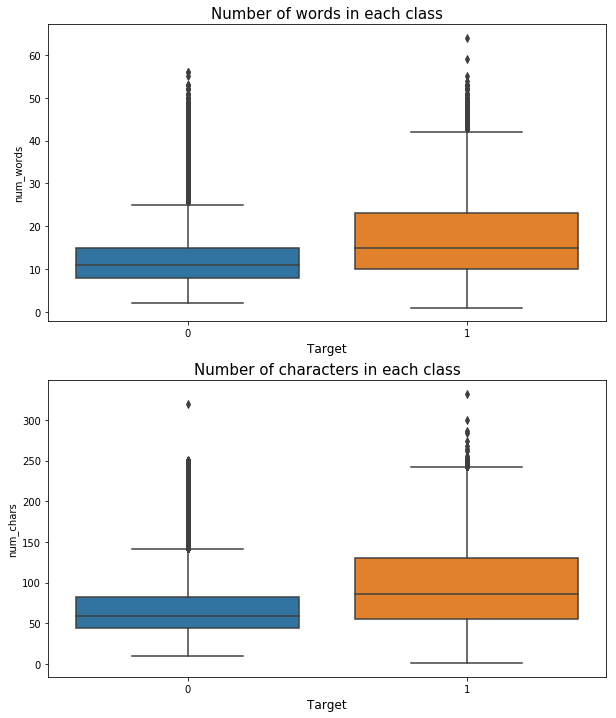

In [28]:
f, axes = plt.subplots(2, 1, figsize=(10,12))
sns.boxplot(x='target', y='num_words', data=df_Quora, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=df_Quora, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)


We can see that Insincere Questions usually tend to have more number of words. In the next notebook, I will do the Initial Text preprocessing and create a Deep Learning baseline Model. 

### License
MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.